# Anomalies in Time Series Data

**Lesson Goals**

- Use entropy as a quick way to identify fields that may have anomalies. 

- Use statistical properties to flag the data points that deviate from the expected. 

**The Data**

- Logs of API requests to our data containing sales information about our stores and items. 

- `https://python.zach.lol/access.log`

- Type of target variable: **Continuous** or Discrete

- Type of observations: **Time Series** or Point in Time   


**The Questions**

- Are there unusual IP addresses accessing our data via the API? 

- Have we seen any spikes or unusual patterns in the size of requests? 

- In general: Does this new value deviate from what we would expect based on historical data? If so, is it something to be concerned about? Remember, we aren't detecting anomalies for the sake of detecting anomalies. 


_____________________________


## Wrangle Data

**Prepare Environment**

In [263]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()


**Acquire**

After doing some research, some experimentation of performing actions and watching the logs, we discovered what each of the fields represent. We then parse and name the fields accordingly. 

In [264]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

For this research, we are only interested in the IP address, timestamp and size of the requests. 

In [265]:
df = df[['ip', 'timestamp', 'size']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ip         13974 non-null  object
 1   timestamp  13974 non-null  object
 2   size       13974 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 327.6+ KB


In [266]:
df.head(2)

,ip,timestamp,size
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],512495
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],3561


**Explore IP Address**

In this sample data, it's pretty easy to take a look at value counts to see those IP's that are rare. However, usually the data is much, much larger and looking at simple value counts is not going to be enough. 

Look at the distribution of the frequency of ip addresses. Are the events made up of thousands of IP addresses that occur only a handful of time?  Are the events made up of only a few IP addresses that occur most of the time, but then a few that are seen only a handful of times? 

In [267]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()

# rename columns
ip_counts.columns=['ip', 'event_count']

# get the number of ip addresses seen 1, or 2, or 11,998 times. 
ip_counts.groupby(['event_count']).count()

,ip
event_count,
1,10
2,3
21,2
246,1
613,1
1059,1
11998,1


Find the IP addresses that only occur once. 

In [268]:
# filter where event_count == 1
ip_counts[ip_counts['event_count'] == 1]

,ip,event_count
9,54.172.14.223,1
10,52.91.30.150,1
11,3.88.129.158,1
12,54.145.52.184,1
13,45.23.250.16,1
14,34.207.64.242,1
15,35.174.209.2,1
16,52.90.165.200,1
17,34.229.70.250,1
18,3.92.201.136,1


We can also get a glimpse into the questions above by computing entropy, using `scipy.stats.entropy`

"In probability theory, the entropy of a random variable measures the uncertainty about the value that might be assumed by the variable."
http://www.scholarpedia.org/article/Entropy

An entropy of 0 indicates there is no uncertainty. In other words, the value will always be one value. An entropy of 1 indicates every value is different. When using entropy in anomaly detection, fields with a low, but not 0 entropy is likely to contain an anomalous value. This is clearly not going to catch all anomalies, but it is another tool to put in your toolbox. 

In [269]:
from scipy.stats import entropy

# pass the entropy function an array-like object of counts. 
entropy(ip_counts.event_count)

0.5648495339393655

An entropy of .56 does not tell there is a clear anomaly, but it also does not tell me there is NOT one. 
This is useful when you have a bunch of variables and don't know where to start or want to be sure you arent missing something obvious. You could loop through your variables computing entropy for each one. 

_________________________________


**Prepare Data to Explore Size**

First, we will resample the existing data to daily increments. 

In [270]:
df.head(2)

,ip,timestamp,size
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],512495
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],3561


First, we need to put the timestamp in a more standard format. 
We will use regular expressions to remove the brackets. 
Then we will replace the first colon ':' with a space. 
At that point, the pandas function to_datetime should be able to read the timestamp and convert it correctly to datetime format. 

In [271]:
# remove brackets and timezone (+0000) by replacing them with empty string ''
df.timestamp = df.timestamp.str.replace(r'(\[|\]|\+0{4})', '', regex=True)
df.head(1)

,ip,timestamp,size
0,97.105.19.58,16/Apr/2019:19:34:42,512495


In [272]:
# replace the first colon, the one that separates date from time,
# with a space
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

df.head(1)

,ip,timestamp,size
0,97.105.19.58,2019-04-16 19:34:42,512495


In [273]:
# set the index to timestamp
df = df.set_index('timestamp')
df.head(1)

,ip,size
timestamp,,
2019-04-16 19:34:42,97.105.19.58,512495


In [274]:
# resample by day, summing the size
df = df[['size']].resample('1d').sum()
df.head(1)

,size
timestamp,
2019-04-16,5480479212


In [275]:
# fill missing values with 0
df = df.fillna(value=0)

# summary stats of the size
df.describe()

,size
count,2.000000e+00
mean,3.143457e+09
std,3.305049e+09
min,8.064345e+08
25%,1.974946e+09
50%,3.143457e+09
75%,4.311968e+09
max,5.480479e+09


**Aside: Simulate some new data to manufacture some anomalies**

1. Create a dataframe starting 4/18/2018 through the next year, setting values for size to 0. 

2. Use the mean and standard deviation of our original data in df to set boundaries for generating random values for our new dataset that fit into the original distribution. 

3. Randomly select a few datapoints to replace the values with anomalous values, and fill with random values that are above expected values. 

4. combine the newly generated dataset with the original. 

*create the dataframe*

In [276]:
new = pd.DataFrame({'timestamp': pd.date_range('20190418', periods=365),
                    'size': 0}).set_index('timestamp')

new.head(2)

,size
timestamp,
2019-04-18,0
2019-04-19,0


*generate new values between* `[0, mean+2*standard deviation]`

In [277]:
# get mean and standard deviation for randomly generating some data. 
mean = df['size'].mean()
std = df['size'].std()

# for all values of 0, fill with random value between 0 and mean + 2*stdev
new['size'] = new['size'].apply(lambda x: np.random.randint(0, mean+2*std) if x==0 else x)

new.describe()

,size
count,3.650000e+02
mean,4.988211e+09
std,2.806937e+09
min,2.755127e+06
25%,2.490948e+09
50%,5.161725e+09
75%,7.394058e+09
max,9.739753e+09


*Fill with some anomalies by replacing 5 random datapoints with a random number between* `[(mean+2*std), (mean+5*std)]`

In [278]:
# take a random sample of 5 datapoints
sample = new.sample(n = 5) 

# for each sample, replace the size with a random number between our range. 
for i in sample.index.values:
    new.loc[i] = np.random.randint(mean+3*std, mean+5*std)

In [279]:
new.describe()

,size
count,3.650000e+02
mean,5.128019e+09
std,3.019121e+09
min,2.755127e+06
25%,2.519723e+09
50%,5.217593e+09
75%,7.506117e+09
max,1.710383e+10


*Concatenate our new data with our original data.*

In [280]:
df = pd.concat([df, new])

print(df.head(2))
print(df.tail(2))

                  size
timestamp             
2019-04-16  5480479212
2019-04-17   806434530
                  size
timestamp             
2020-04-15  2403052153
2020-04-16  4352108668


(array([62., 62., 54., 66., 75., 43.,  0.,  3.,  0.,  2.]),
 array([2.75512700e+06, 1.71286293e+09, 3.42297072e+09, 5.13307852e+09,
        6.84318632e+09, 8.55329412e+09, 1.02634019e+10, 1.19735097e+10,
        1.36836175e+10, 1.53937253e+10, 1.71038331e+10]),
 <a list of 10 Patch objects>)

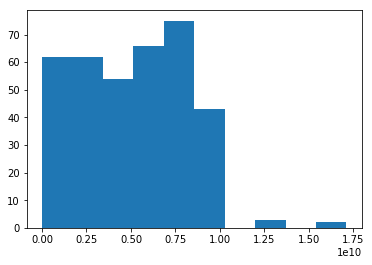

In [281]:
plt.hist(df['size'])

## Explore Size

First, let's represent size in GB for ease of conceptual understanding.  

In [282]:
df['size_gb'] = [n/1024/1024/1024 for n in df['size']]
df = df[['size_gb']]

In [283]:
df.describe()

,size_gb
count,367.000000
mean,4.765767
std,2.811998
min,0.002566
25%,2.333276
50%,4.859262
75%,6.981844
max,15.929186


**Split into Train/Test**

- train: 2019-04-16 => 2019-10-15

- validate: 2019-10-16 => 2020-01-15

- test: 2020-01-16 => 2020-04-16

In [284]:
train = df[:'2019-10-15']
validate = df['2019-10-16':'2020-01-15']
test = df['2020-01-16':]

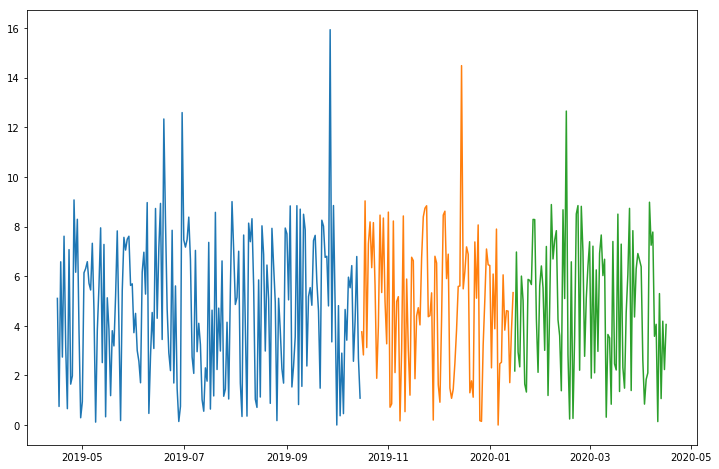

In [285]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

## Simple Moving Average

First, let's compute the simple moving average in order to compare to the exponential moving average. We will compute a few different windows, 7 days, 14 days, and 30 days. 

Notice that with the simple moving average, using `df.rolling(window=7).mean()`, when there are fewer than 7 values of history to compute, like on 2019-04-16 (the first day of data that we have), the result will be NaN. 


In [286]:
# 1 week
sma_short = train.rolling(window=7).mean()
sma_short[4:9]

,size_gb
timestamp,
2019-04-20,NaN
2019-04-21,NaN
2019-04-22,3.800981
2019-04-23,4.081627
2019-04-24,4.210097


In [287]:
# 14 day
sma_mid = train.rolling(window=14).mean()
sma_mid[11:16]

,size_gb
timestamp,
2019-04-27,NaN
2019-04-28,NaN
2019-04-29,4.617304
2019-04-30,4.273845
2019-05-01,4.287619


In [288]:
# 30 day
sma_long = train.rolling(window=30).mean()
sma_long[27:32]

,size_gb
timestamp,
2019-05-13,NaN
2019-05-14,NaN
2019-05-15,4.520379
2019-05-16,4.521178
2019-05-17,4.624832


**Plot the SMA**

Text(0, 0.5, 'Size (MB)')

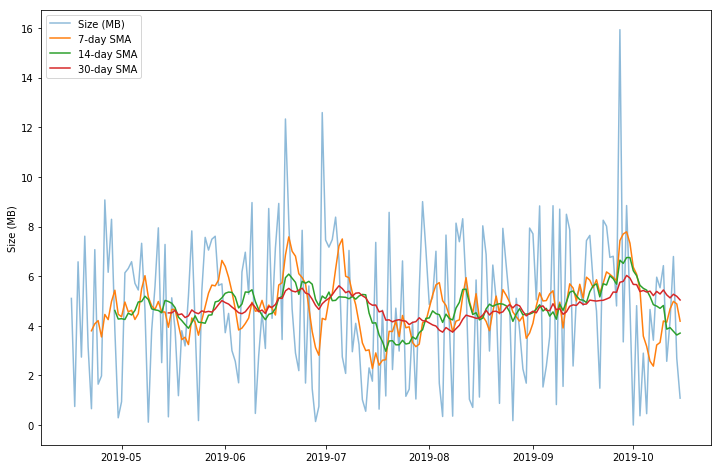

In [289]:

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_short, label = '7-day SMA')

ax.plot(train.index, sma_mid, label = '14-day SMA')

ax.plot(train.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')
# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

Go ahead and try some other windows to compare. 

## Exponential Moving Average

SMA time series are much less noisy than the time series of the original data points. 
The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units. 

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this: 

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where: 

- M = Number of time periods, span of the window

- $t_{0}$ = Latest value

- $t-1$ = Previous value

- $EMA_{t-1}$ = Exponential moving average of previous day. 

- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. 
So we just need to define the following: 

- M = `span` argument = number of time periods. We will try 7 days, 14 days, and 30 days. 

- Notice how there are no missing values. ewm() will use as many values are available to compute the mean. So if the span is 7 days, but it is on the first day of data available, the EMA will equal the first value. 

In [290]:
# 7 days EMA
ema_short = train.ewm(span=7).mean()
ema_short.head()

,size_gb
timestamp,
2019-04-16,5.104094
2019-04-17,2.616641
2019-04-18,4.329877
2019-04-19,3.748510
2019-04-20,5.014209


In [291]:
# 14 days EMA
ema_mid = train.ewm(span=14).mean()
ema_mid.head()

,size_gb
timestamp,
2019-04-16,5.104094
2019-04-17,2.772107
2019-04-18,4.226162
2019-04-19,3.771565
2019-04-20,4.772976


In [292]:
# 30 days EMA
ema_long = train.ewm(span=30).mean()
ema_long.head()

,size_gb
timestamp,
2019-04-16,5.104094
2019-04-17,2.855022
2019-04-18,4.179814
2019-04-19,3.783148
2019-04-20,4.653822


**Comparison of SMA and EMA**

The exponential moving average puts more weight on the more recent values, while maintaining information about values before the window span through inclusion of the previous period's EMA in the formula. When comparing the plots below, take a look at how the spikes impact the SMA vs. the EMA. 

7-Day SMA vs. EMA

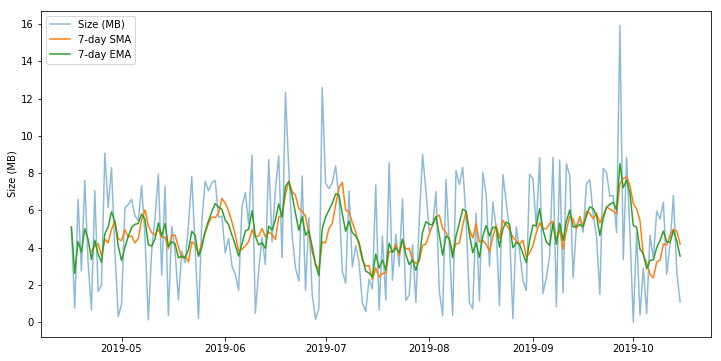

In [293]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_short, label = '7-day SMA')
ax.plot(train.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

14-Day SMA vs. EMA

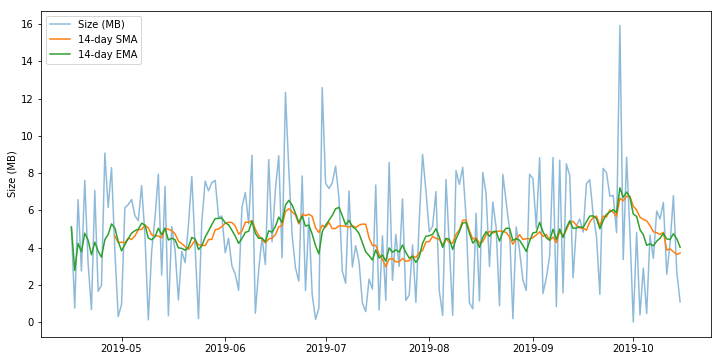

In [294]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_mid, label = '14-day SMA')
ax.plot(train.index, ema_mid, label = '14-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

30-Day SMA vs. EMA

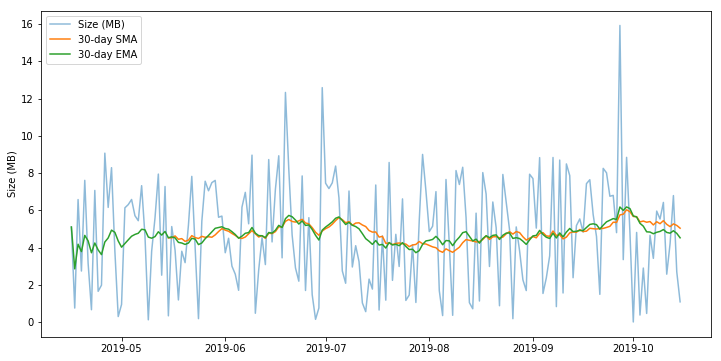

In [295]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_long, label = '30-day SMA')
ax.plot(train.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

# ax.xaxis.(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

If I know the spikes are completely unexpected and do not want those to impact the expected values, then the longer EMA is the way to go. 

## Bollinger Bands and %b

**Bollinger Bands**

- a volatility indicator and commonly used in stock market trading. 

- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.  

**Midband**

- The Exponential Moving Average

- `midband = train.ewm(span=30).mean()`

**Upper & Lower Band**

- UB/LB = Midband +/- stdev * K

- `stdev = train.ewm(span=30).std()` 

- K = the number of standard deviations to go up and down from the EMA

**%b, Percent Bandwidth**

- Shows where the last value sits in relation to the bands

- $\%b = \frac{last-LB}{UB-LB}$ 

- %b > 1 => point lies above UB

- %b < 0 => point lies below LB

- %b == .5 => point lies on the midband. 

**Bandwidth** 

- The width of the bands

- $Bandwidth = \frac{(UB-LB)}{Midband}$


In [296]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()

midband.head(2)

,size_gb
timestamp,
2019-04-16,5.104094
2019-04-17,2.855022


In [297]:
# compute exponential stdev
stdev = train.ewm(span=span).std()

stdev.head(2)

,size_gb
timestamp,
2019-04-16,NaN
2019-04-17,3.078066


In [298]:
# compute upper and lower bands
ub = midband + stdev*2
lb = midband - stdev*2

# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.head(3)

,size_gb,size_gb
timestamp,,
2019-04-16,NaN,NaN
2019-04-17,9.011155,-3.301111
2019-04-18,10.296365,-1.936737


In [299]:
train = pd.concat([train, midband, bb], axis=1)
train.columns = ['size_gb', 'midband', 'ub', 'lb']

In [300]:
train.head(3)

,size_gb,midband,ub,lb
timestamp,,,,
2019-04-16,5.104094,5.104094,NaN,NaN
2019-04-17,0.751051,2.855022,9.011155,-3.301111
2019-04-18,6.578500,4.179814,10.296365,-1.936737


Plot the bands

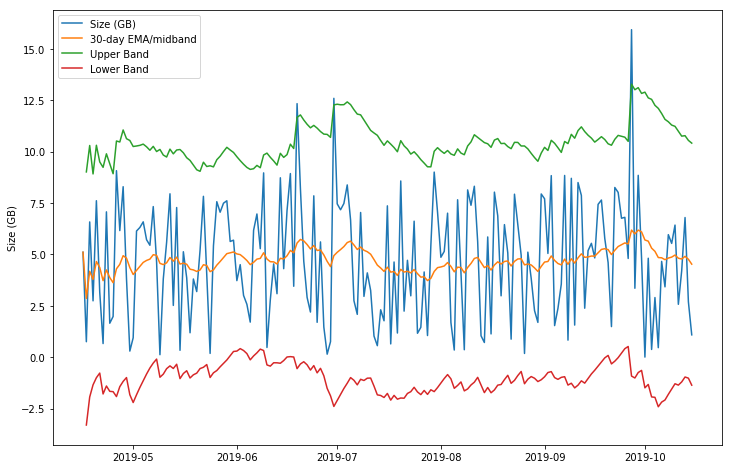

In [301]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train.size_gb, label='Size (GB)')

ax.plot(train.index, train.midband, label = '30-day EMA/midband')
ax.plot(train.index, train.ub, label = 'Upper Band')
ax.plot(train.index, train.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (GB)')

plt.show()

Where do you think we will have a %b > 1? 

Compute %b

$\%b = \frac{last-LB}{UB-LB}$ 

Each row/time period, will have a %b value that answers the question, where does this point sit with respect to the expected value when considering the values before it. For example, we could take the last value in train and manually compute %b: 

In [312]:
# get the last measure of gb
last_measure = train.iloc[-1].size_gb


# get the lower band value on the last date
last_lb = train.iloc[-1].lb

# get the upper band value on the last date
last_ub = train.iloc[-1].ub

# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.21


So, to compute for each point in time: 

In [314]:
train['pct_b'] = (train['size_gb'] - train['lb'])/(train['ub'] - train['lb'])

train.head(2)

,size_gb,midband,ub,lb,pct_b
timestamp,,,,,
2019-04-16,5.104094,5.104094,NaN,NaN,NaN
2019-04-17,0.751051,2.855022,9.011155,-3.301111,0.329116


Now, where do we see anomalies? We will search for %b values > 1. We don't need to search for values < 0 because with this example, a low extreme is not something we are concerned about. 

In [315]:
train[train['pct_b']>1]

,size_gb,midband,ub,lb,pct_b
timestamp,,,,,
2019-06-19,12.332057,5.552896,11.664108,-0.558316,1.054649
2019-06-30,12.589850,4.936653,12.270207,-2.396901,1.021793
2019-09-27,15.929186,6.180557,13.280139,-0.919026,1.186564


## Exercises

**file name:** time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:

Can you label students who are viewing both the web dev and data science curriculum?
Can you label students by the program they are in? 
Can you label users by student vs. staff?
What are Zach, Maggie, Faith, and Ryan's ids?